[refer](https://github.com/rlcode/reinforcement-learning/blob/master/2-cartpole/4-actor-critic/cartpole_a2c.py)

In [1]:
import sys
import gym
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

EPISODES = 1000

Using TensorFlow backend.


In [2]:
class AgentA2C(object):
    
    def __init__(self, state_size, action_size):
        self.render = False
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        self.batch_size = 1
        
        self.discount_factor = 0.99
        self.action_learning_rate = 1e-3
        self.critic_learning_rate = 5e-3
        
        self.actor = self._build_actor()
        self.critic = self._build_critic()
        
    def _build_actor(self):
        actor = Sequential()
        actor.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='he_uniform'))
        actor.compile(Adam(self.action_learning_rate), 'categorical_crossentropy')
        actor.summary()
        return actor
    
    def _build_critic(self):
        critic = Sequential()
        critic.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='he_uniform'))
        critic.compile(Adam(self.critic_learning_rate), 'mse')
        critic.summary()
        return critic
    
    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    def train_op(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0] 
        
        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

In [3]:
# In case of CartPole-v1, maximum length of episode is 500
env = gym.make('CartPole-v1')
# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# make A2C agent
agent = AgentA2C(state_size, action_size)

scores, episodes = [], []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [4]:
for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.expand_dims(state, 0)
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.expand_dims(next_state, 0)
        
        reward = reward if not done or score ==499 else -100
        agent.train_op(state, action, reward, next_state, done)

        score += reward
        state = next_state
        
        if done:
            score = score if score == 500.0 else score + 100
            scores.append(score)
            episodes.append(e)
            
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                break
        


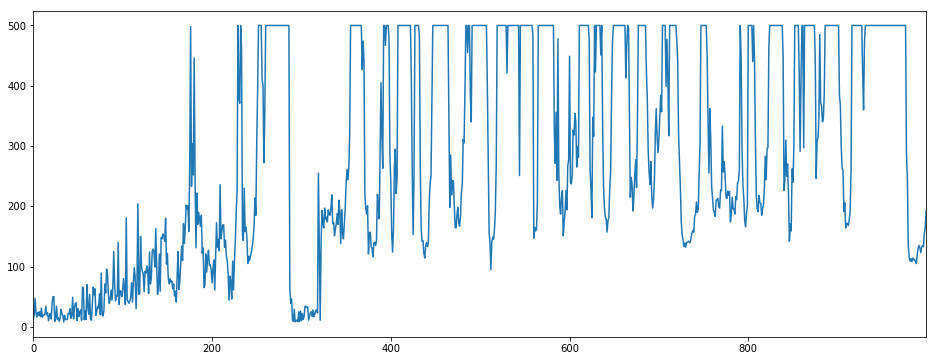

In [5]:
pd.Series(scores).plot(figsize=(16,6))